# Data

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from skimage.color import rgb2lab
from skimage import color

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.layers import Input
from keras.layers import RepeatVector, Reshape,  concatenate, BatchNormalization

from keras.applications.inception_resnet_v2 import InceptionResNetV2


from keras.models import  Model






In [14]:
folder_path = "/kaggle/input/celeba-zip/celeba25k"


In [ ]:
L_portret = np.empty((10000,256,256,1),'float32')
ab_portret = np.empty((10000,256,256,2), 'float32')
i = 0

for filename in os.listdir(folder_path):
    if i == 10000:
        break
    print(i)

    image_path = os.path.join(folder_path, filename)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     # photo resizing
    upper = (image.shape[0] - image.shape[1])//2
    new_height = image.shape[1]
    image = image[upper: upper + new_height, :]

    # photo scaling
    image = cv2.resize(image, (256, 256))

    # splitting photo into L, a, and b channels

    lab = rgb2lab((1.0/255)*image)
    L_portret[i] = (lab[:,:,0]).reshape(256,256,1)
    ab_portret[i] = (lab[:,:,1:]).reshape(256,256,2)

    i +=1

In [16]:
with open('ab_256_10000.npy', 'wb') as ab_file:
  np.save(ab_file, ab_portret)

In [17]:
with open('L_256_10000.npy', 'wb') as L_file:
  np.save(L_file, L_portret)

### Loading datasets

In [29]:
L = np.load('/kaggle/working/L_256_10000.npy')[: 2000]
ab = np.load('/kaggle/working/ab_256_10000.npy')[: 2000]

### Splitting data

In [ ]:
L_train, L_test, ab_train, ab_test = train_test_split(L, ab, test_size=0.1, random_state=54)

# Inception model

In [8]:
X = L_train
y = ab_train / 128

In [9]:
inception = InceptionResNetV2(include_top=True, weights='imagenet') # download the Inception ResNet v2 neural network

In [10]:
x_res = np.empty((len(X),299,299,3), 'float32')
img_res = np.empty((299,299,3), 'float32')
for i in range(len(X)):
  img = (X[i])
  img = cv2.resize(img,(299,299))
  img = img.reshape(299,299)
  img_res[:,:,0] = img
  img_res[:,:,1] = img
  img_res[:,:,2] = img
  x_res[i] = img_res

In [11]:
res_out = inception.predict(x_res)

 2/57 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step  

I0000 00:00:1713976766.683318     219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 419ms/step


In [13]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)




#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input)
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)



#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

In [14]:
model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

In [15]:
model.fit([X,res_out],
         y,
         epochs = 15)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 416ms/step - loss: 0.0942
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0100
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0102
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0112
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0094
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0103
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0091
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0090
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0084
Epoch 10/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0080
Epoch 11/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0081
Epoch 12/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0080
Epoch 13/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0076
Epoch 14/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0083
Epoch 15/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - l

In [16]:
x_res_test = np.empty((len(L_test),299,299,3), 'float32')
img_res = np.empty((299,299,3), 'float32')
for i in range(len(L_test)):
  img = (L_test[i]).reshape(256,256)
  img = cv2.resize(img,(299,299))
  img = img.reshape(299,299)
  img_res[:,:,0] = img
  img_res[:,:,1] = img
  img_res[:,:,2] = img
  x_res[i] = img_res

In [17]:
res_out_test = inception.predict(x_res_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


In [18]:
output = model.predict([L_test, res_out_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


In [19]:
Lab_pred = np.concatenate((L_test, output * 128), axis=-1)
RGB_pred = color.lab2rgb(Lab_pred)
Lab = np.concatenate((L_test, ab_test), axis=-1)
RGB = color.lab2rgb(Lab)

/tmp/ipykernel_177/1300809895.py:2: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 504 negative Z values that have been clipped to zero
  RGB_pred = color.lab2rgb(Lab_pred)


ValueError: num must be an integer with 1 <= num <= 10, not 11

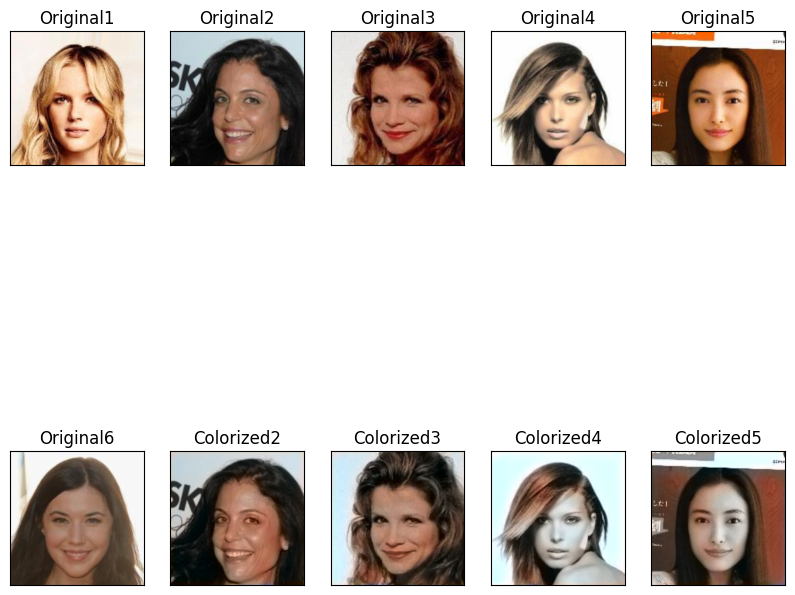

In [21]:
shift_image = 0
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(RGB[i + shift_image])
    # plt.axis('off')
    plt.title('Original{}'.format(i + 1))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 5, i + 5 + 1)
    plt.imshow(RGB_pred[i + shift_image])
    # plt.axis('off')
    plt.title('Colorized{}'.format(i + 1))
    plt.xticks([])
    plt.yticks([])

plt.show()